# Meteorology Uncertainty Quantification
# Regression Analysis for Air Temperature, Humidity, and Soil Moisture

This notebook performs comprehensive regression analysis on three meteorological targets:
- **Air Temperature Error** (Ta_C_error)
- **Humidity Error** (RH_error)  
- **Soil Moisture Error** (SM_error)

For each target, we analyze the relationship with independent variables and build OLS regression models with proper statistical inference.

## 1. Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from JET3 import load_ECOv002_calval_JET_outputs, INPUT_VARIABLES

# Set plot style
plt.style.use('default')
sns.set_palette("husl")

## 2. Load and Prepare Data

In [2]:
# Load ECOv002 calibration/validation data
df = load_ECOv002_calval_JET_outputs()

# Prepare in-situ reference data
df["insitu_RH"] = df["RH_percentage"]
df["insitu_SM"] = df["SM_surf"]

# Add LST error column
df["ST_C_error"] = df["LST_err"]
df["NDVI_error"] = df["NDVI-UQ"]
df["albedo_error"] = df["albedo-UQ"]    

# Calculate error metrics for all three targets
df["Ta_C_error"] = df["Ta_C"] - df["insitu_Ta_C"]
df["Ta_C_error_abs"] = np.abs(df["Ta_C_error"])

df["RH_error"] = df["RH"] - df["insitu_RH"]
df["RH_error_abs"] = np.abs(df["RH_error"])

df["SM_error"] = df["SM"] - df["insitu_SM"]
df["SM_error_abs"] = np.abs(df["SM_error"])

print(f"Dataset shape: {df.shape}")
print(f"\nAvailable columns: {len(df.columns)}")
df.head()

Dataset shape: (1065, 191)

Available columns: 191


/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_97475/2395300302.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["insitu_SM"] = df["SM_surf"]
/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_97475/2395300302.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["ST_C_error"] = df["LST_err"]
/var/folders/hk/35_x93nx79vg1zmd2fy1vcbr0000gq/T/ipykernel_97475/2395300302.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,insitu_SM,ST_C_error,NDVI_error,albedo_error,Ta_C_error,Ta_C_error_abs,RH_error,RH_error_abs,SM_error,SM_error_abs
0,0,US-NC3,ENF,Cfa,270.34520,78.53355,392.85184,307.02197,487.383423,118.91628,...,0.201566,2.56,0.015808,0.015761,0.857850,0.857850,-0.076633,0.076633,-0.009207,0.009207
1,1,US-Mi3,CVM,Dfb,232.14160,229.20093,640.11847,375.08930,106.825577,167.91946,...,0.420438,1.16,0.013800,0.006056,-2.004618,2.004618,NaN,NaN,-0.127222,0.127222
2,2,US-Mi3,CVM,Dfb,356.35574,335.23154,625.66170,284.68625,NaN,132.93634,...,0.406938,2.12,0.025352,0.005914,-4.084138,4.084138,NaN,NaN,0.026498,0.026498
3,3,US-Mi3,CVM,Dfb,332.93840,326.68680,624.25433,251.41449,178.827545,141.13242,...,0.398036,1.48,0.000998,0.000996,-1.106204,1.106204,NaN,NaN,-0.006793,0.006793
4,4,US-Mi3,CVM,Dfb,286.85403,237.21654,511.08218,228.52017,154.791626,114.80941,...,0.397494,1.88,0.000963,0.000845,-1.053609,1.053609,NaN,NaN,-0.063624,0.063624


## 3. Define Independent Variables

In [3]:
# Define independent variables for regression analysis
INPUT_VARIABLES = [
    "NDVI",
    "ST_C",
    "SZA_deg",
    "albedo",
    "canopy_height_meters",
    "elevation_m",
    "emissivity",
    "wind_speed_mps",
]

# Verify all variables are in the dataset
vars_in_df = [v for v in INPUT_VARIABLES if v in df.columns]
missing_vars = [v for v in INPUT_VARIABLES if v not in df.columns]

print(f"Independent Variables Available: {len(vars_in_df)}")
print(f"  {', '.join(vars_in_df)}")
if missing_vars:
    print(f"\nMissing Variables: {len(missing_vars)}")
    print(f"  {', '.join(missing_vars)}")

Independent Variables Available: 8
  NDVI, ST_C, SZA_deg, albedo, canopy_height_meters, elevation_m, emissivity, wind_speed_mps


## 4. Exploratory Data Analysis

### 4.1 Summary Statistics for Error Metrics

In [4]:
# Summary statistics for all three error metrics
error_metrics = ['Ta_C_error', 'RH_error', 'SM_error']
error_summary = df[error_metrics].describe()

print("=" * 80)
print("ERROR METRICS SUMMARY STATISTICS")
print("=" * 80)
print(error_summary.to_string(float_format=lambda x: f'{x:.4f}'))
print("\n")

# RMSE for each target
for metric in error_metrics:
    rmse = np.sqrt(np.nanmean(df[metric]**2))
    mae = np.nanmean(df[metric + '_abs'])
    print(f"{metric:20s} RMSE = {rmse:8.4f}  |  MAE = {mae:8.4f}")

ERROR METRICS SUMMARY STATISTICS
       Ta_C_error  RH_error  SM_error
count   1048.0000 1027.0000  833.0000
mean       0.9463    0.1138    0.0301
std        2.5847    0.1186    0.0937
min       -8.1564   -0.3955   -0.5442
25%       -0.6063    0.0384   -0.0094
50%        0.7325    0.1349    0.0338
75%        2.2244    0.2068    0.0727
max       14.9174    0.4845    0.6013


Ta_C_error           RMSE =   2.7514  |  MAE =   2.0251
RH_error             RMSE =   0.1643  |  MAE =   0.1425
SM_error             RMSE =   0.0983  |  MAE =   0.0727


### 4.2 Visualize Error Distributions

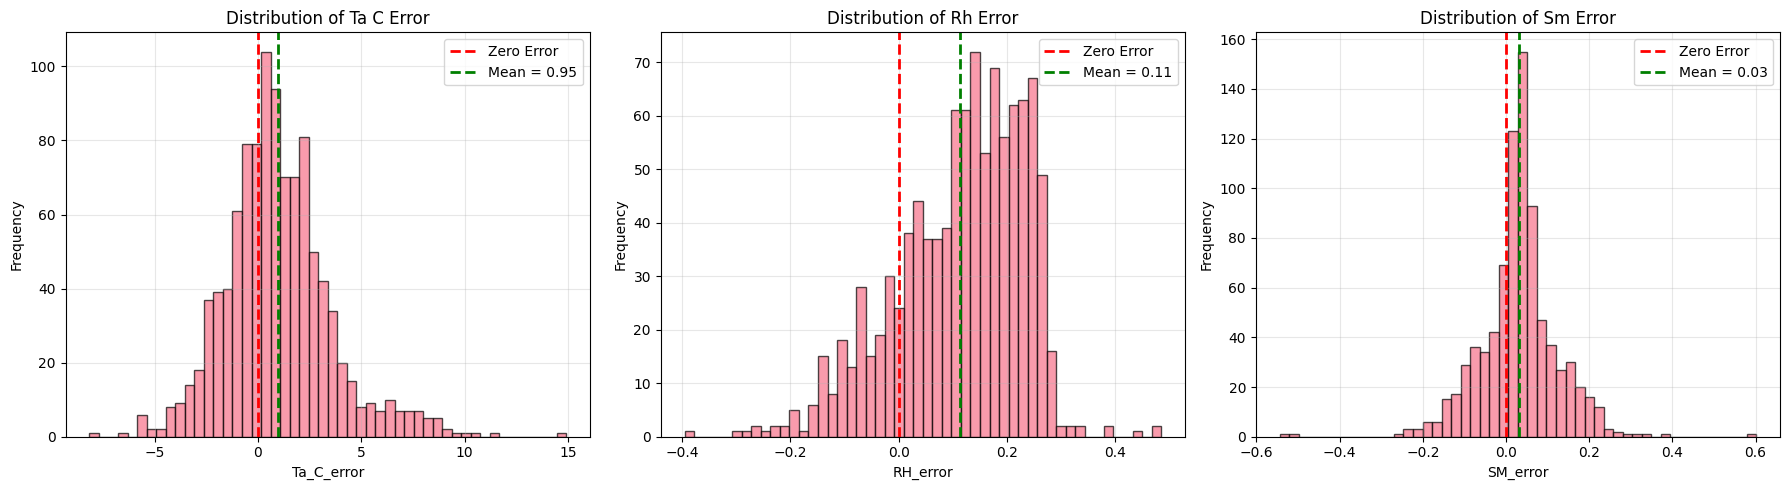

In [5]:
# Distribution plots for all three error metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (ax, metric) in enumerate(zip(axes, error_metrics)):
    data = df[metric].dropna()
    ax.hist(data, bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
    ax.axvline(data.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean = {data.mean():.2f}')
    ax.set_xlabel(f'{metric}')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {metric.replace("_", " ").title()}')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

## 5. Correlation Analysis

### 5.1 Function to Calculate Correlations

In [6]:
def calculate_correlations(df, target_col, input_vars):
    """
    Calculate correlation statistics between input variables and target.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    target_col : str
        Name of target column
    input_vars : list
        List of independent variable names
        
    Returns:
    --------
    DataFrame with correlation statistics
    """
    vars_in_df = [v for v in input_vars if v in df.columns]
    numeric_vars = df[vars_in_df].select_dtypes(include=[np.number]).columns.tolist()
    
    rows = []
    for var in numeric_vars:
        pair = df[[var, target_col]].dropna()
        if len(pair) < 3:
            continue
        
        r, p = pearsonr(pair[var], pair[target_col])
        if not (np.isfinite(r) and np.isfinite(p)):
            continue
        
        rows.append({
            "variable": var,
            "correlation": r,
            "r_square": r**2,
            "p_value": p,
            "n": len(pair),
        })
    
    corr_stats = (
        pd.DataFrame(rows)
        .sort_values(by="correlation", key=lambda s: s.abs(), ascending=False)
        .set_index("variable")
    )
    
    return corr_stats

### 5.2 Calculate Correlations for All Three Targets

In [7]:
# Calculate correlations for all three targets
target_cols = ['Ta_C_error_abs', 'RH_error_abs', 'SM_error_abs']
corr_results = {}

for target in target_cols:
    corr_results[target] = calculate_correlations(df, target, INPUT_VARIABLES)
    
    print("=" * 80)
    print(f"CORRELATIONS WITH {target}")
    print("=" * 80)
    print(corr_results[target].to_string(float_format=lambda x: f'{x:.4f}'))
    print("\n")

CORRELATIONS WITH Ta_C_error_abs
                      correlation  r_square  p_value     n
variable                                                  
elevation_m                0.4559    0.2078   0.0000  1048
canopy_height_meters      -0.1526    0.0233   0.0000  1048
SZA_deg                   -0.1349    0.0182   0.0000  1048
NDVI                      -0.1331    0.0177   0.0000  1048
ST_C                       0.1208    0.0146   0.0001  1048
albedo                    -0.0584    0.0034   0.0587  1048
emissivity                -0.0199    0.0004   0.5208  1048
wind_speed_mps            -0.0147    0.0002   0.6342  1046


CORRELATIONS WITH RH_error_abs
                      correlation  r_square  p_value     n
variable                                                  
NDVI                      -0.3629    0.1317   0.0000  1027
ST_C                       0.3573    0.1276   0.0000  1027
wind_speed_mps             0.2310    0.0534   0.0000  1025
canopy_height_meters      -0.1992    0.0397   0.0

### 5.3 Visualize Correlations Across All Targets

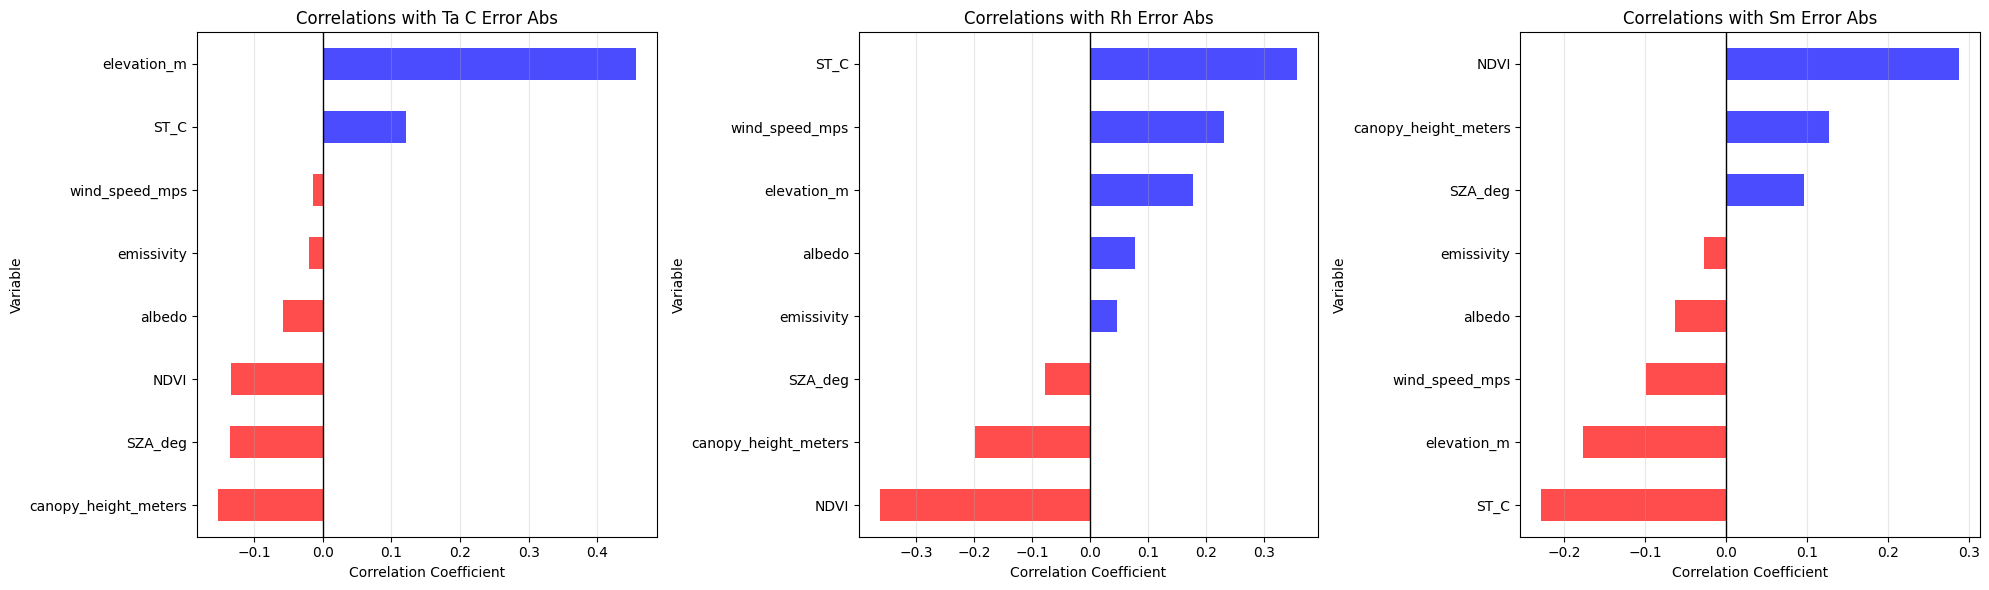

In [8]:
# Create comparison plot of correlations across all three targets
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (ax, target) in enumerate(zip(axes, target_cols)):
    correlations = corr_results[target]['correlation'].sort_values()
    colors = ['red' if c < 0 else 'blue' for c in correlations]
    
    correlations.plot(kind='barh', ax=ax, color=colors, alpha=0.7)
    ax.set_xlabel('Correlation Coefficient')
    ax.set_ylabel('Variable')
    ax.set_title(f'Correlations with {target.replace("_", " ").title()}')
    ax.grid(True, axis='x', alpha=0.3)
    ax.axvline(0, color='black', linewidth=1)

plt.tight_layout()
plt.show()

## 6. OLS Regression Analysis

### 6.1 Function to Perform OLS Regression with Statistical Inference

In [9]:
def perform_ols_regression(df, target_col, input_vars, top_n=None):
    """
    Perform OLS regression with statistical inference.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    target_col : str
        Name of target column
    input_vars : list or DataFrame index
        Independent variables to use
    top_n : int, optional
        Number of top correlated variables to use
        
    Returns:
    --------
    dict with regression results
    """
    # If input_vars is a correlation result, extract variable names
    if isinstance(input_vars, pd.core.indexes.base.Index):
        if top_n:
            predictor_vars = input_vars[:top_n].tolist()
        else:
            predictor_vars = input_vars.tolist()
    else:
        predictor_vars = input_vars
    
    # Prepare data
    X = df[predictor_vars].dropna()
    y = df.loc[X.index, target_col].dropna()
    
    # Align X and y
    common_idx = X.index.intersection(y.index)
    X = X.loc[common_idx]
    y = y.loc[common_idx]
    
    # Fit OLS regression (scikit-learn)
    ols_model = LinearRegression()
    ols_model.fit(X, y)
    
    # Fit OLS regression (statsmodels for inference)
    X_sm = sm.add_constant(X, has_constant="add")
    ols_inference = sm.OLS(y, X_sm).fit()
    
    # Get coefficients with p-values
    coef_df = pd.DataFrame({
        'Variable': predictor_vars,
        'Coefficient': ols_model.coef_,
        'p_value': ols_inference.pvalues.reindex(predictor_vars).values
    }).sort_values('Coefficient', key=lambda x: x.abs(), ascending=False)
    
    # Calculate predictions and metrics
    y_pred = ols_model.predict(X)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    
    # Calculate VIF
    vif_vals = []
    for i, col in enumerate(X.columns):
        vif_vals.append((col, variance_inflation_factor(X.values, i)))
    vif_df = pd.DataFrame(vif_vals, columns=['Variable', 'VIF']).sort_values('VIF', ascending=False)
    
    return {
        'model': ols_model,
        'inference': ols_inference,
        'coefficients': coef_df,
        'vif': vif_df,
        'X': X,
        'y': y,
        'y_pred': y_pred,
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'predictor_vars': predictor_vars
    }

### 6.2 Air Temperature Regression Model

In [10]:
# Use top correlated variables for air temperature
ta_results = perform_ols_regression(
    df, 
    'Ta_C_error', 
    corr_results['Ta_C_error_abs'].index,
    top_n=len(INPUT_VARIABLES)
)

print("=" * 80)
print("AIR TEMPERATURE REGRESSION RESULTS")
print("=" * 80)
print(f"\nModel Performance:")
print(f"  R² = {ta_results['r2']:.4f}")
print(f"  RMSE = {ta_results['rmse']:.4f}")
print(f"  MAE = {ta_results['mae']:.4f}")
print(f"  Observations = {len(ta_results['y'])}")

print(f"\nRegression Coefficients:")
print(ta_results['coefficients'].to_string(index=False, float_format=lambda v: f"{v:.6f}"))

print(f"\nVariance Inflation Factors (VIF):")
print(ta_results['vif'].to_string(index=False, float_format=lambda v: f"{v:.2f}"))

AIR TEMPERATURE REGRESSION RESULTS

Model Performance:
  R² = 0.2973
  RMSE = 2.1664
  MAE = 1.6223
  Observations = 1046

Regression Coefficients:
            Variable  Coefficient  p_value
          emissivity    -5.516014 0.295179
                NDVI     1.901556 0.000012
              albedo     1.461571 0.248946
      wind_speed_mps    -0.074569 0.139483
             SZA_deg    -0.043550 0.000000
canopy_height_meters    -0.033969 0.001008
         elevation_m     0.002203 0.000000
                ST_C     0.000150 0.984830

Variance Inflation Factors (VIF):
            Variable   VIF
          emissivity 88.19
             SZA_deg 18.26
                ST_C 13.24
                NDVI 10.60
         elevation_m  5.97
              albedo  5.16
      wind_speed_mps  4.72
canopy_height_meters  2.84


### 6.3 Humidity Regression Model

In [11]:
# Use top correlated variables for humidity
rh_results = perform_ols_regression(
    df, 
    'RH_error', 
    corr_results['RH_error_abs'].index,
    top_n=len(INPUT_VARIABLES)
)

print("=" * 80)
print("HUMIDITY REGRESSION RESULTS")
print("=" * 80)
print(f"\nModel Performance:")
print(f"  R² = {rh_results['r2']:.4f}")
print(f"  RMSE = {rh_results['rmse']:.4f}")
print(f"  MAE = {rh_results['mae']:.4f}")
print(f"  Observations = {len(rh_results['y'])}")

print(f"\nRegression Coefficients:")
print(rh_results['coefficients'].to_string(index=False, float_format=lambda v: f"{v:.6f}"))

print(f"\nVariance Inflation Factors (VIF):")
print(rh_results['vif'].to_string(index=False, float_format=lambda v: f"{v:.2f}"))

HUMIDITY REGRESSION RESULTS

Model Performance:
  R² = 0.2938
  RMSE = 0.0996
  MAE = 0.0743
  Observations = 1025

Regression Coefficients:
            Variable  Coefficient  p_value
          emissivity     0.627991 0.013898
                NDVI    -0.180705 0.000000
              albedo    -0.045821 0.433552
      wind_speed_mps     0.009642 0.000048
                ST_C     0.003984 0.000000
canopy_height_meters     0.002941 0.000000
             SZA_deg     0.001061 0.000243
         elevation_m     0.000004 0.543059

Variance Inflation Factors (VIF):
            Variable   VIF
          emissivity 89.85
             SZA_deg 18.53
                ST_C 13.23
                NDVI 10.47
         elevation_m  6.06
              albedo  5.12
      wind_speed_mps  4.82
canopy_height_meters  2.90


### 6.4 Soil Moisture Regression Model

In [12]:
# Use top correlated variables for soil moisture
sm_results = perform_ols_regression(
    df, 
    'SM_error', 
    corr_results['SM_error_abs'].index,
    top_n=len(INPUT_VARIABLES)
)

print("=" * 80)
print("SOIL MOISTURE REGRESSION RESULTS")
print("=" * 80)
print(f"\nModel Performance:")
print(f"  R² = {sm_results['r2']:.4f}")
print(f"  RMSE = {sm_results['rmse']:.4f}")
print(f"  MAE = {sm_results['mae']:.4f}")
print(f"  Observations = {len(sm_results['y'])}")

print(f"\nRegression Coefficients:")
print(sm_results['coefficients'].to_string(index=False, float_format=lambda v: f"{v:.6f}"))

print(f"\nVariance Inflation Factors (VIF):")
print(sm_results['vif'].to_string(index=False, float_format=lambda v: f"{v:.2f}"))

SOIL MOISTURE REGRESSION RESULTS

Model Performance:
  R² = 0.0577
  RMSE = 0.0910
  MAE = 0.0622
  Observations = 831

Regression Coefficients:
            Variable  Coefficient  p_value
          emissivity     0.306941 0.205742
                NDVI     0.064063 0.002051
              albedo     0.034349 0.546930
      wind_speed_mps    -0.005046 0.033931
canopy_height_meters    -0.001974 0.000027
             SZA_deg     0.000488 0.086359
                ST_C     0.000152 0.682499
         elevation_m     0.000031 0.000005

Variance Inflation Factors (VIF):
            Variable   VIF
          emissivity 85.87
             SZA_deg 17.43
                ST_C 12.57
                NDVI 11.77
         elevation_m  5.90
              albedo  5.07
      wind_speed_mps  4.54
canopy_height_meters  3.12


## 7. Variable Retention (No Pruning)

### 7.1 Selection Disabled (Keep All Predictors)

In [13]:
# Variable selection is disabled to keep all predictors in the regression analysis.

def select_all_variables(corr_stats, regression_results):
    """
    Build a selection table without pruning any variables.
    """
    vif_dict = dict(zip(
        regression_results['vif']['Variable'],
        regression_results['vif']['VIF']
    ))
    coef_dict = dict(zip(
        regression_results['coefficients']['Variable'],
        regression_results['coefficients']['Coefficient']
    ))
    pval_dict = dict(zip(
        regression_results['coefficients']['Variable'],
        regression_results['coefficients']['p_value']
    ))

    selection_df = pd.DataFrame({
        'correlation': corr_stats['correlation'],
        'abs_correlation': corr_stats['correlation'].abs(),
        'p_value': corr_stats.index.map(pval_dict),
        'vif': corr_stats.index.map(vif_dict),
        'coefficient': corr_stats.index.map(coef_dict)
    })

    selection_df['selected'] = True
    selection_df = selection_df.sort_values('abs_correlation', ascending=False)

    return selection_df

### 7.2 Apply Variable Selection to All Targets

In [14]:
# Retain all variables for all three targets (no pruning)
ta_selection = select_all_variables(
    corr_results['Ta_C_error_abs'],
    ta_results
)

rh_selection = select_all_variables(
    corr_results['RH_error_abs'],
    rh_results
)

sm_selection = select_all_variables(
    corr_results['SM_error_abs'],
    sm_results
)

# Print retention results
for target_name, selection_df in [
    ('Air Temperature', ta_selection),
    ('Humidity', rh_selection),
    ('Soil Moisture', sm_selection)
]:
    selected_vars = selection_df.index.tolist()

    print("=" * 80)
    print(f"VARIABLE RETENTION: {target_name.upper()}")
    print("=" * 80)
    print("\nAll variables retained; no pruning applied.\n")
    print(f"Variables ({len(selected_vars)}):")

    for var in selected_vars:
        row = selection_df.loc[var]
        print(
            f"  ✓ {var:25s} | r={row['correlation']:7.3f} | "
            f"p={row['p_value']:.4f} | VIF={row['vif']:6.2f}"
        )

    print("\n")

VARIABLE RETENTION: AIR TEMPERATURE

All variables retained; no pruning applied.

Variables (8):
  ✓ elevation_m               | r=  0.456 | p=0.0000 | VIF=  5.97
  ✓ canopy_height_meters      | r= -0.153 | p=0.0010 | VIF=  2.84
  ✓ SZA_deg                   | r= -0.135 | p=0.0000 | VIF= 18.26
  ✓ NDVI                      | r= -0.133 | p=0.0000 | VIF= 10.60
  ✓ ST_C                      | r=  0.121 | p=0.9848 | VIF= 13.24
  ✓ albedo                    | r= -0.058 | p=0.2489 | VIF=  5.16
  ✓ emissivity                | r= -0.020 | p=0.2952 | VIF= 88.19
  ✓ wind_speed_mps            | r= -0.015 | p=0.1395 | VIF=  4.72


VARIABLE RETENTION: HUMIDITY

All variables retained; no pruning applied.

Variables (8):
  ✓ NDVI                      | r= -0.363 | p=0.0000 | VIF= 10.47
  ✓ ST_C                      | r=  0.357 | p=0.0000 | VIF= 13.23
  ✓ wind_speed_mps            | r=  0.231 | p=0.0000 | VIF=  4.82
  ✓ canopy_height_meters      | r= -0.199 | p=0.0000 | VIF=  2.90
  ✓ elevation_m    

## 8. Full Models with All Variables

### 8.1 Use Original Models (No Refit Needed)

In [15]:
# Use original models with all variables (no pruning or refit)
ta_refined = ta_results
rh_refined = rh_results
sm_refined = sm_results

# Print model results
for target_name, results in [
    ('Air Temperature', ta_refined),
    ('Humidity', rh_refined),
    ('Soil Moisture', sm_refined)
]:
    print("=" * 80)
    print(f"FULL MODEL: {target_name.upper()}")
    print("=" * 80)

    print(f"\nModel Performance:")
    print(f"  R² = {results['r2']:.4f}  |  RMSE = {results['rmse']:.4f}")
    print(f"  MAE = {results['mae']:.4f}")
    print(f"  Variables used: {len(results['predictor_vars'])}")
    print(f"  {', '.join(results['predictor_vars'])}")

    print("\n")

FULL MODEL: AIR TEMPERATURE

Model Performance:
  R² = 0.2973  |  RMSE = 2.1664
  MAE = 1.6223
  Variables used: 8
  elevation_m, canopy_height_meters, SZA_deg, NDVI, ST_C, albedo, emissivity, wind_speed_mps


FULL MODEL: HUMIDITY

Model Performance:
  R² = 0.2938  |  RMSE = 0.0996
  MAE = 0.0743
  Variables used: 8
  NDVI, ST_C, wind_speed_mps, canopy_height_meters, elevation_m, albedo, SZA_deg, emissivity


FULL MODEL: SOIL MOISTURE

Model Performance:
  R² = 0.0577  |  RMSE = 0.0910
  MAE = 0.0622
  Variables used: 8
  NDVI, ST_C, elevation_m, canopy_height_meters, wind_speed_mps, SZA_deg, albedo, emissivity




## 9. Model Comparison and Evaluation

### 9.1 Compare Performance Across All Three Targets

MODEL PERFORMANCE COMPARISON (Normalized Metrics)

Note: NRMSE and NMAE are normalized as percentages of mean absolute observed value
This allows fair comparison across variables with different units

         Target  N Variables   R²  NRMSE (%)  NMAE (%)  N Observations
Air Temperature            8 0.30     107.04     80.16            1046
       Humidity            8 0.29      69.97     52.20            1025
  Soil Moisture            8 0.06     125.11     85.53             831


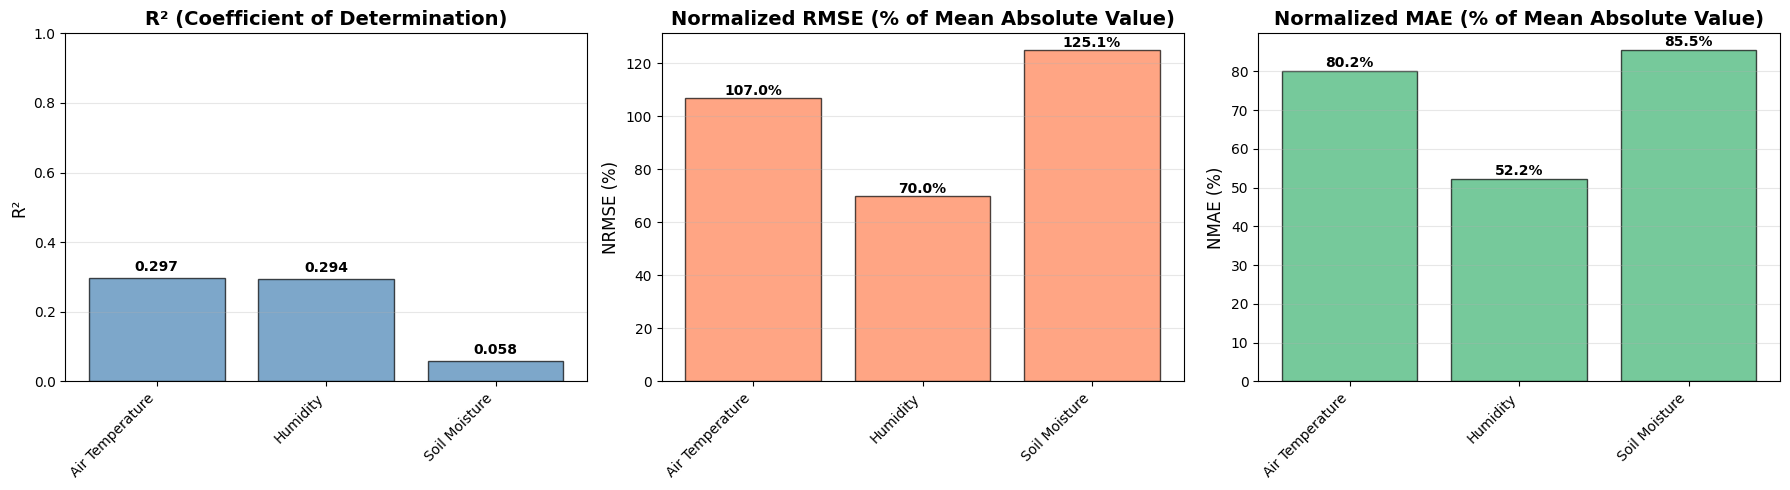

In [16]:
# Create comparison table with normalized metrics
comparison_data = []

for target_name, refined, original in [
    ('Air Temperature', ta_refined, ta_results),
    ('Humidity', rh_refined, rh_results),
    ('Soil Moisture', sm_refined, sm_results)
]:
    results = refined if refined else original
    y = results['y']
    y_pred = results['y_pred']
    
    # Calculate normalized metrics for fair comparison across different units
    # NRMSE: Normalized RMSE as percentage of mean absolute value
    mean_abs_y = np.nanmean(np.abs(y))
    nrmse_pct = (results['rmse'] / mean_abs_y * 100) if mean_abs_y != 0 else np.nan
    
    # Normalized MAE as percentage
    nmae_pct = (results['mae'] / mean_abs_y * 100) if mean_abs_y != 0 else np.nan
    
    comparison_data.append({
        'Target': target_name,
        'N Variables': len(results['predictor_vars']),
        'R²': results['r2'],
        'NRMSE (%)': nrmse_pct,
        'NMAE (%)': nmae_pct,
        'N Observations': len(results['y'])
    })

comparison_df = pd.DataFrame(comparison_data)

print("=" * 90)
print("MODEL PERFORMANCE COMPARISON (Normalized Metrics)")
print("=" * 90)
print("\nNote: NRMSE and NMAE are normalized as percentages of mean absolute observed value")
print("This allows fair comparison across variables with different units\n")
print(comparison_df.to_string(index=False, float_format=lambda x: f'{x:.2f}'))

# Visualize comparison using normalized metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R² comparison
axes[0].bar(comparison_df['Target'], comparison_df['R²'], alpha=0.7, edgecolor='black', color='steelblue')
axes[0].set_ylabel('R²', fontsize=12)
axes[0].set_title('R² (Coefficient of Determination)', fontsize=14, fontweight='bold')
axes[0].grid(True, axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

axes[0].set_xticklabels(comparison_df['Target'], rotation=45, ha='right')
for i, v in enumerate(comparison_df['R²']):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# NRMSE comparison
axes[1].bar(comparison_df['Target'], comparison_df['NRMSE (%)'], alpha=0.7, edgecolor='black', color='coral')
axes[1].set_ylabel('NRMSE (%)', fontsize=12)
axes[1].set_title('Normalized RMSE (% of Mean Absolute Value)', fontsize=14, fontweight='bold')
axes[1].grid(True, axis='y', alpha=0.3)
axes[1].set_xticklabels(comparison_df['Target'], rotation=45, ha='right')
for i, v in enumerate(comparison_df['NRMSE (%)']):
    axes[1].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

# NMAE comparison  
axes[2].bar(comparison_df['Target'], comparison_df['NMAE (%)'], alpha=0.7, edgecolor='black', color='mediumseagreen')
axes[2].set_ylabel('NMAE (%)', fontsize=12)
axes[2].set_title('Normalized MAE (% of Mean Absolute Value)', fontsize=14, fontweight='bold')
axes[2].grid(True, axis='y', alpha=0.3)
axes[2].set_xticklabels(comparison_df['Target'], rotation=45, ha='right')
for i, v in enumerate(comparison_df['NMAE (%)']):
    axes[2].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


## 10. Residual Analysis

### 10.1 Predicted vs Observed Plots

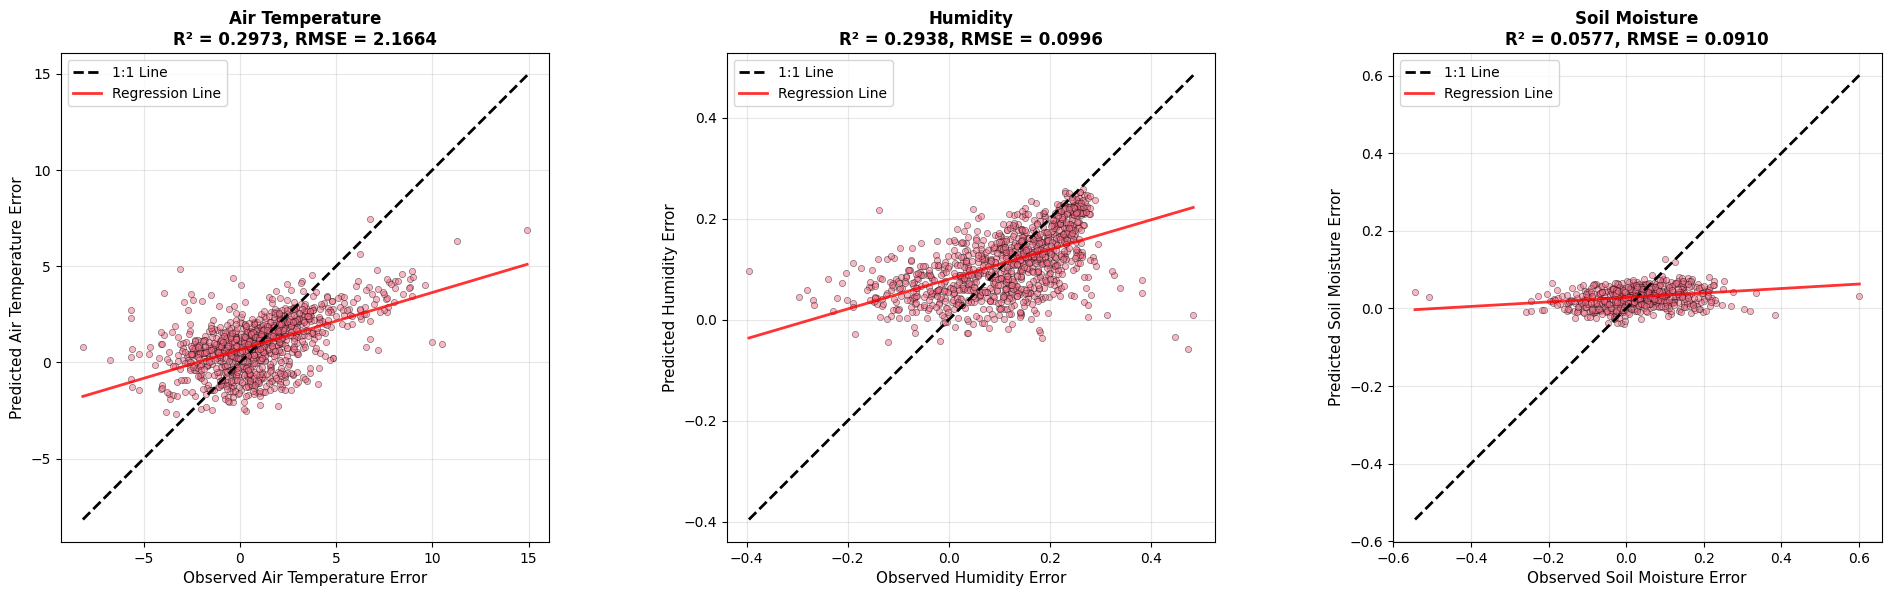

In [17]:
# Create predicted vs observed plots for all three targets
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, (target_name, results) in zip(axes, [
    ('Air Temperature', ta_refined if ta_refined else ta_results),
    ('Humidity', rh_refined if rh_refined else rh_results),
    ('Soil Moisture', sm_refined if sm_refined else sm_results)
]):
    y_true = results['y']
    y_pred = results['y_pred']
    
    ax.scatter(y_true, y_pred, alpha=0.5, s=20, edgecolors='black', linewidth=0.5)
    
    # Add 1:1 line
    min_lim = min(y_true.min(), y_pred.min())
    max_lim = max(y_true.max(), y_pred.max())
    ax.plot([min_lim, max_lim], [min_lim, max_lim], 'k--', linewidth=2, label='1:1 Line')
    
    # Add regression line
    z = np.polyfit(y_true, y_pred, 1)
    p = np.poly1d(z)
    ax.plot([min_lim, max_lim], p([min_lim, max_lim]), 'r-', linewidth=2, alpha=0.8, label='Regression Line')
    
    ax.set_xlabel(f'Observed {target_name} Error', fontsize=11)
    ax.set_ylabel(f'Predicted {target_name} Error', fontsize=11)
    ax.set_title(f'{target_name}\nR² = {results["r2"]:.4f}, RMSE = {results["rmse"]:.4f}', 
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best')
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

### 10.2 Residual Distribution Plots

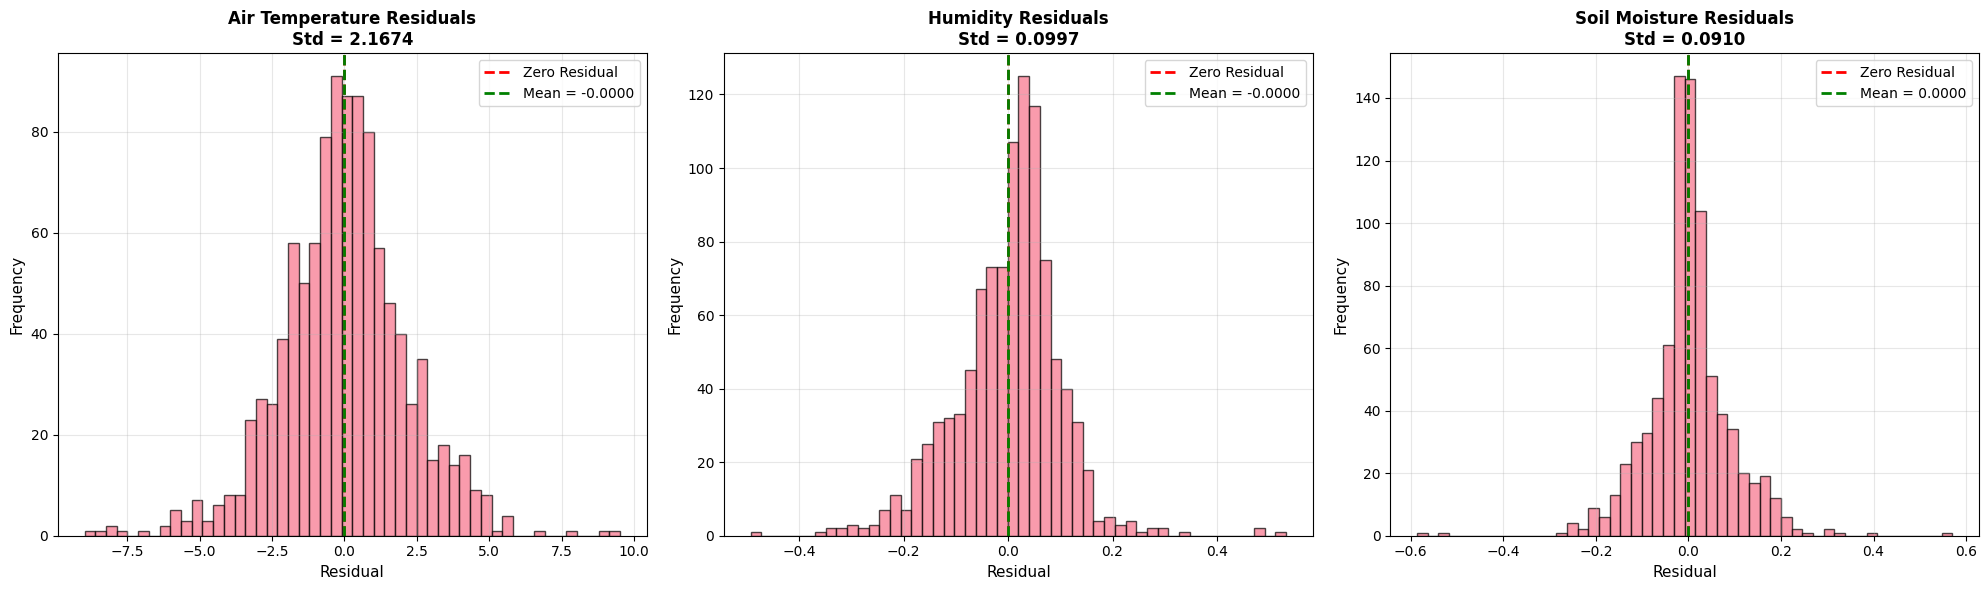

In [18]:
# Residual distribution plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, (target_name, results) in zip(axes, [
    ('Air Temperature', ta_refined if ta_refined else ta_results),
    ('Humidity', rh_refined if rh_refined else rh_results),
    ('Soil Moisture', sm_refined if sm_refined else sm_results)
]):
    residuals = results['y'] - results['y_pred']
    
    ax.hist(residuals, bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Residual')
    ax.axvline(residuals.mean(), color='green', linestyle='--', linewidth=2, 
              label=f'Mean = {residuals.mean():.4f}')
    
    ax.set_xlabel('Residual', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'{target_name} Residuals\nStd = {residuals.std():.4f}', 
                fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

### 10.3 Residuals vs Fitted Values

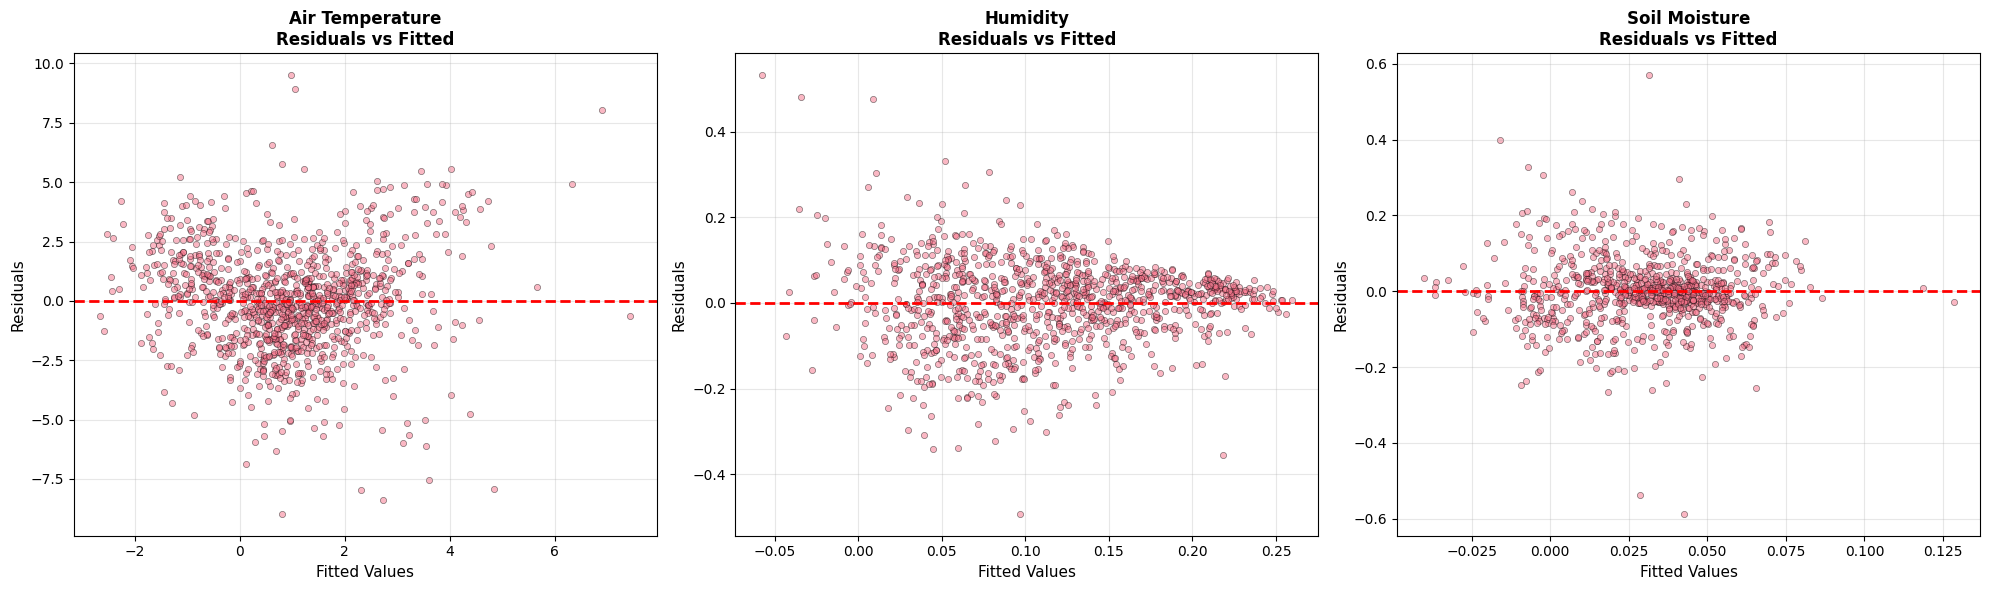

In [19]:
# Residuals vs fitted values plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, (target_name, results) in zip(axes, [
    ('Air Temperature', ta_refined if ta_refined else ta_results),
    ('Humidity', rh_refined if rh_refined else rh_results),
    ('Soil Moisture', sm_refined if sm_refined else sm_results)
]):
    residuals = results['y'] - results['y_pred']
    fitted = results['y_pred']
    
    ax.scatter(fitted, residuals, alpha=0.5, s=20, edgecolors='black', linewidth=0.5)
    ax.axhline(0, color='red', linestyle='--', linewidth=2)
    ax.set_xlabel('Fitted Values', fontsize=11)
    ax.set_ylabel('Residuals', fontsize=11)
    ax.set_title(f'{target_name}\nResiduals vs Fitted', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Feature Importance Analysis

### 11.1 Compare Variable Importance Across Targets

COEFFICIENT COMPARISON ACROSS TARGETS
            Variable  Ta_C_coef  Ta_C_pval  RH_coef  RH_pval  SM_coef  SM_pval
                NDVI     1.9016     0.0000  -0.1807   0.0000   0.0641   0.0021
                ST_C     0.0002     0.9848   0.0040   0.0000   0.0002   0.6825
             SZA_deg    -0.0436     0.0000   0.0011   0.0002   0.0005   0.0864
              albedo     1.4616     0.2489  -0.0458   0.4336   0.0343   0.5469
canopy_height_meters    -0.0340     0.0010   0.0029   0.0000  -0.0020   0.0000
         elevation_m     0.0022     0.0000   0.0000   0.5431   0.0000   0.0000
          emissivity    -5.5160     0.2952   0.6280   0.0139   0.3069   0.2057
      wind_speed_mps    -0.0746     0.1395   0.0096   0.0000  -0.0050   0.0339


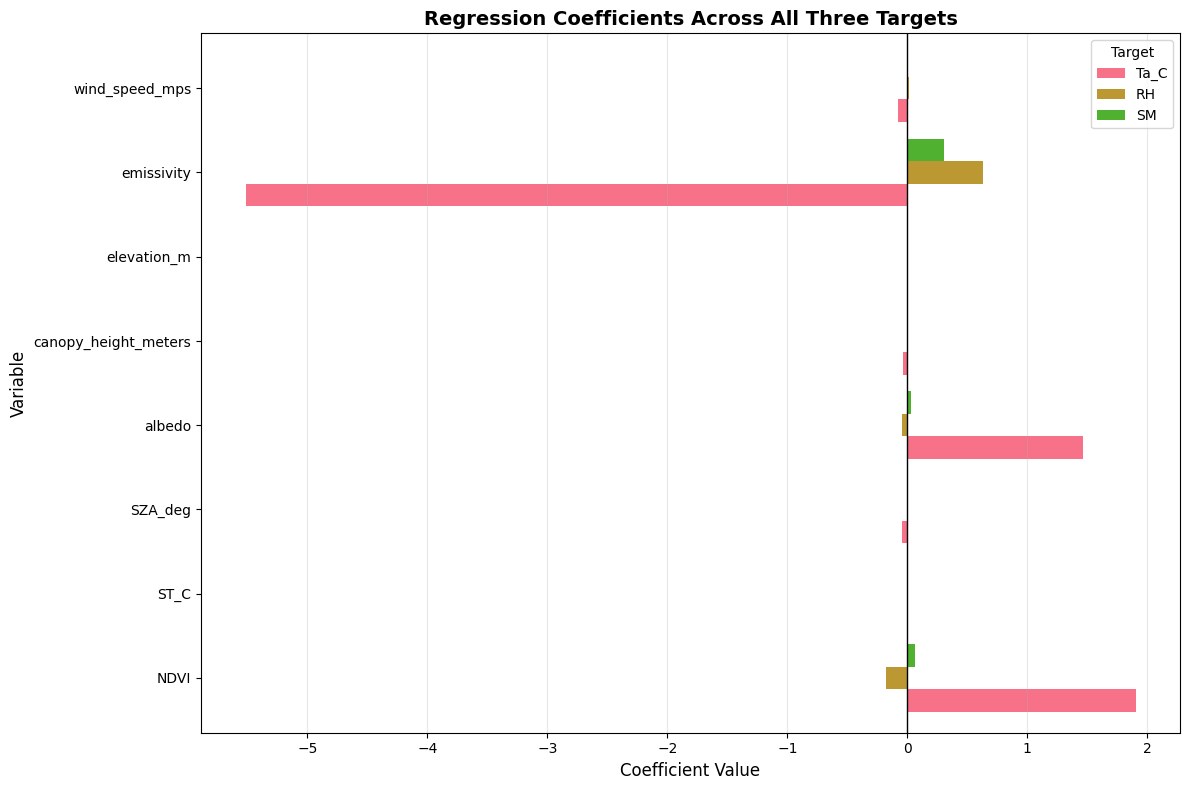

In [20]:
# Create feature importance comparison
all_vars = set()
for results in [ta_refined or ta_results, rh_refined or rh_results, sm_refined or sm_results]:
    all_vars.update(results['predictor_vars'])

# Build comparison dataframe
importance_data = []
for var in sorted(all_vars):
    row = {'Variable': var}
    
    for target_name, results in [
        ('Ta_C', ta_refined or ta_results),
        ('RH', rh_refined or rh_results),
        ('SM', sm_refined or sm_results)
    ]:
        if var in results['predictor_vars']:
            coef = results['coefficients'][results['coefficients']['Variable'] == var]['Coefficient'].values[0]
            pval = results['coefficients'][results['coefficients']['Variable'] == var]['p_value'].values[0]
            row[f'{target_name}_coef'] = coef
            row[f'{target_name}_pval'] = pval
        else:
            row[f'{target_name}_coef'] = np.nan
            row[f'{target_name}_pval'] = np.nan
    
    importance_data.append(row)

importance_df = pd.DataFrame(importance_data)

print("=" * 80)
print("COEFFICIENT COMPARISON ACROSS TARGETS")
print("=" * 80)
print(importance_df.to_string(index=False, float_format=lambda x: f'{x:.4f}' if pd.notna(x) else 'N/A'))

# Visualize coefficient comparison
coef_cols = [col for col in importance_df.columns if col.endswith('_coef')]
plot_df = importance_df.set_index('Variable')[coef_cols]
plot_df.columns = [col.replace('_coef', '') for col in plot_df.columns]

fig, ax = plt.subplots(figsize=(12, 8))
plot_df.plot(kind='barh', ax=ax, width=0.8)
ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_ylabel('Variable', fontsize=12)
ax.set_title('Regression Coefficients Across All Three Targets', fontsize=14, fontweight='bold')
ax.grid(True, axis='x', alpha=0.3)
ax.legend(title='Target', loc='best')
ax.axvline(0, color='black', linewidth=1)

plt.tight_layout()
plt.show()

## 12. Summary and Conclusions

In [21]:
print("=" * 80)
print("METEOROLOGY UNCERTAINTY QUANTIFICATION - SUMMARY")
print("=" * 80)

print("\n📊 MODEL PERFORMANCE SUMMARY:\n")
for target_name, results in [
    ('Air Temperature Error', ta_refined or ta_results),
    ('Humidity Error', rh_refined or rh_results),
    ('Soil Moisture Error', sm_refined or sm_results)
]:
    print(f"{target_name}:")
    print(f"  • R² = {results['r2']:.4f}")
    print(f"  • RMSE = {results['rmse']:.4f}")
    print(f"  • MAE = {results['mae']:.4f}")
    print(f"  • Variables used: {len(results['predictor_vars'])}")
    print(f"    {', '.join(results['predictor_vars'])}")
    print()

print("=" * 80)
print("\n🔑 KEY FINDINGS:\n")

# Identify common important variables
ta_vars = set((ta_refined or ta_results)['predictor_vars'])
rh_vars = set((rh_refined or rh_results)['predictor_vars'])
sm_vars = set((sm_refined or sm_results)['predictor_vars'])

common_vars = ta_vars & rh_vars & sm_vars
print(f"Variables important for ALL three targets ({len(common_vars)}):")
for var in sorted(common_vars):
    print(f"  • {var}")

print(f"\nVariables unique to Air Temperature ({len(ta_vars - rh_vars - sm_vars)}):")
for var in sorted(ta_vars - rh_vars - sm_vars):
    print(f"  • {var}")

print(f"\nVariables unique to Humidity ({len(rh_vars - ta_vars - sm_vars)}):")
for var in sorted(rh_vars - ta_vars - sm_vars):
    print(f"  • {var}")

print(f"\nVariables unique to Soil Moisture ({len(sm_vars - ta_vars - rh_vars)}):")
for var in sorted(sm_vars - ta_vars - rh_vars):
    print(f"  • {var}")

print("\n" + "=" * 80)

METEOROLOGY UNCERTAINTY QUANTIFICATION - SUMMARY

📊 MODEL PERFORMANCE SUMMARY:

Air Temperature Error:
  • R² = 0.2973
  • RMSE = 2.1664
  • MAE = 1.6223
  • Variables used: 8
    elevation_m, canopy_height_meters, SZA_deg, NDVI, ST_C, albedo, emissivity, wind_speed_mps

Humidity Error:
  • R² = 0.2938
  • RMSE = 0.0996
  • MAE = 0.0743
  • Variables used: 8
    NDVI, ST_C, wind_speed_mps, canopy_height_meters, elevation_m, albedo, SZA_deg, emissivity

Soil Moisture Error:
  • R² = 0.0577
  • RMSE = 0.0910
  • MAE = 0.0622
  • Variables used: 8
    NDVI, ST_C, elevation_m, canopy_height_meters, wind_speed_mps, SZA_deg, albedo, emissivity


🔑 KEY FINDINGS:

Variables important for ALL three targets (8):
  • NDVI
  • ST_C
  • SZA_deg
  • albedo
  • canopy_height_meters
  • elevation_m
  • emissivity
  • wind_speed_mps

Variables unique to Air Temperature (0):

Variables unique to Humidity (0):

Variables unique to Soil Moisture (0):



## 13. Generate UQ Data Layers

This section turns the regression results into uncertainty layers that can be applied to gridded inputs.
Two complementary methods are provided:

- **Parametric OLS prediction intervals** using the statsmodels inference object.
- **Empirical residual scaling** to capture heteroskedasticity by binning residuals versus predicted error.

The outputs are per-sample error layers (mean error and uncertainty bounds) that can be attached to spatial grids or
used to build corrected values (e.g., corrected $Ta$ = modeled $Ta$ - predicted error).

In [23]:
def build_uq_layers(results, data, alpha=0.05, bin_count=10):
    """
    Build UQ layers for a target using OLS prediction intervals and empirical residual scaling.

    Returns a DataFrame indexed like data with columns:
    - error_mean: predicted error (mean)
    - error_se: standard error of the mean prediction
    - error_pi_lower/upper: OLS prediction interval bounds
    - error_sigma_empirical: residual-based sigma by predicted-error bins
    - error_pi_emp_lower/upper: empirical interval bounds
    """
    predictor_vars = results['predictor_vars']
    X = data[predictor_vars].copy().dropna()
    if X.empty:
        return pd.DataFrame(index=data.index)

    X_sm = sm.add_constant(X, has_constant="add")
    pred = results['inference'].get_prediction(X_sm)
    pred_summary = pred.summary_frame(alpha=alpha)

    layers = pd.DataFrame(index=X.index)
    layers['error_mean'] = pred_summary['mean']
    layers['error_se'] = pred_summary['mean_se']
    layers['error_pi_lower'] = pred_summary['obs_ci_lower']
    layers['error_pi_upper'] = pred_summary['obs_ci_upper']

    # Empirical residual-based sigma by bins of predicted error
    train_pred = pd.Series(results['y_pred'], index=results['y'].index)
    train_resid = results['y'] - results['y_pred']

    try:
        bin_edges = pd.qcut(train_pred, q=bin_count, retbins=True, duplicates="drop")[1]
    except ValueError:
        quantiles = np.linspace(0, 1, min(bin_count, len(train_pred)))
        bin_edges = np.unique(np.quantile(train_pred, quantiles))

    if len(bin_edges) < 3:
        global_sigma = np.nanstd(train_resid)
        layers['error_sigma_empirical'] = global_sigma
    else:
        train_bins = pd.cut(train_pred, bins=bin_edges, include_lowest=True, duplicates="drop")
        bin_sigma = train_resid.groupby(train_bins).std()
        pred_bins = pd.cut(layers['error_mean'], bins=bin_edges, include_lowest=True, duplicates="drop")
        layers['error_sigma_empirical'] = pred_bins.map(bin_sigma).astype(float)
        layers['error_sigma_empirical'] = layers['error_sigma_empirical'].fillna(np.nanstd(train_resid))

    z = 1.96  # 95% interval for normal errors
    layers['error_pi_emp_lower'] = layers['error_mean'] - z * layers['error_sigma_empirical']
    layers['error_pi_emp_upper'] = layers['error_mean'] + z * layers['error_sigma_empirical']

    return layers


def prefix_columns(frame, prefix):
    return frame.add_prefix(f"{prefix}_")


# Build UQ layers for each target
ta_uq = build_uq_layers(ta_refined or ta_results, df)
rh_uq = build_uq_layers(rh_refined or rh_results, df)
sm_uq = build_uq_layers(sm_refined or sm_results, df)

# Combine into a single table for easy export or mapping
uq_layers = pd.concat(
    [
        prefix_columns(ta_uq, "Ta_C"),
        prefix_columns(rh_uq, "RH"),
        prefix_columns(sm_uq, "SM"),
    ],
    axis=1,
    join="outer",
)

print("UQ layer columns:")
print(uq_layers.columns.tolist())
print("\nSample UQ layers:")
print(uq_layers.head())

UQ layer columns:
['Ta_C_error_mean', 'Ta_C_error_se', 'Ta_C_error_pi_lower', 'Ta_C_error_pi_upper', 'Ta_C_error_sigma_empirical', 'Ta_C_error_pi_emp_lower', 'Ta_C_error_pi_emp_upper', 'RH_error_mean', 'RH_error_se', 'RH_error_pi_lower', 'RH_error_pi_upper', 'RH_error_sigma_empirical', 'RH_error_pi_emp_lower', 'RH_error_pi_emp_upper', 'SM_error_mean', 'SM_error_se', 'SM_error_pi_lower', 'SM_error_pi_upper', 'SM_error_sigma_empirical', 'SM_error_pi_emp_lower', 'SM_error_pi_emp_upper']

Sample UQ layers:
   Ta_C_error_mean  Ta_C_error_se  Ta_C_error_pi_lower  Ta_C_error_pi_upper  \
0        -1.118941       0.242762            -5.414791             3.176909   
1         1.105888       0.243189            -3.190054             5.401831   
2         0.956342       0.223789            -3.335539             5.248223   
3         0.683064       0.196987            -3.603755             4.969883   
4         0.539166       0.191152            -3.746635             4.824968   

   Ta_C_error_sig

In [24]:
# Table of data layers with 1-sigma UQ columns
uq_table = pd.DataFrame(
    [
        {
            "data_layer": "Ta_C",
            "uq_layer_1sigma": "Ta_C_error_sigma_empirical",
        },
        {
            "data_layer": "RH",
            "uq_layer_1sigma": "RH_error_sigma_empirical",
        },
        {
            "data_layer": "SM",
            "uq_layer_1sigma": "SM_error_sigma_empirical",
        },
    ]
)

print("Data layers with 1-sigma UQ columns:")
print(uq_table.to_string(index=False))

# Optional: show actual data/uq values side-by-side for the first few rows
preview_cols = [
    "Ta_C",
    "Ta_C_error_sigma_empirical",
    "RH",
    "RH_error_sigma_empirical",
    "SM",
    "SM_error_sigma_empirical",
]

if "uq_layers" in globals():
    preview = pd.concat([df["Ta_C"], uq_layers["Ta_C_error_sigma_empirical"],
                         df["RH"], uq_layers["RH_error_sigma_empirical"],
                         df["SM"], uq_layers["SM_error_sigma_empirical"]], axis=1)
    preview.columns = preview_cols
    print("\nPreview of values:")
    print(preview.head())

Data layers with 1-sigma UQ columns:
data_layer            uq_layer_1sigma
      Ta_C Ta_C_error_sigma_empirical
        RH   RH_error_sigma_empirical
        SM   SM_error_sigma_empirical

Preview of values:
        Ta_C  Ta_C_error_sigma_empirical        RH  RH_error_sigma_empirical  \
0  32.658920                    1.814819  0.560215                  0.116395   
1  24.227982                    2.213860  0.458503                  0.141146   
2  26.178862                    2.213860  0.621679                  0.123498   
3  22.527096                    1.945542  0.623986                  0.141146   
4  23.280691                    1.905050  0.571613                  0.141146   

         SM  SM_error_sigma_empirical  
0  0.192359                  0.115523  
1  0.293216                  0.108787  
2  0.433436                  0.108787  
3  0.391243                  0.108787  
4  0.333870                  0.089240  


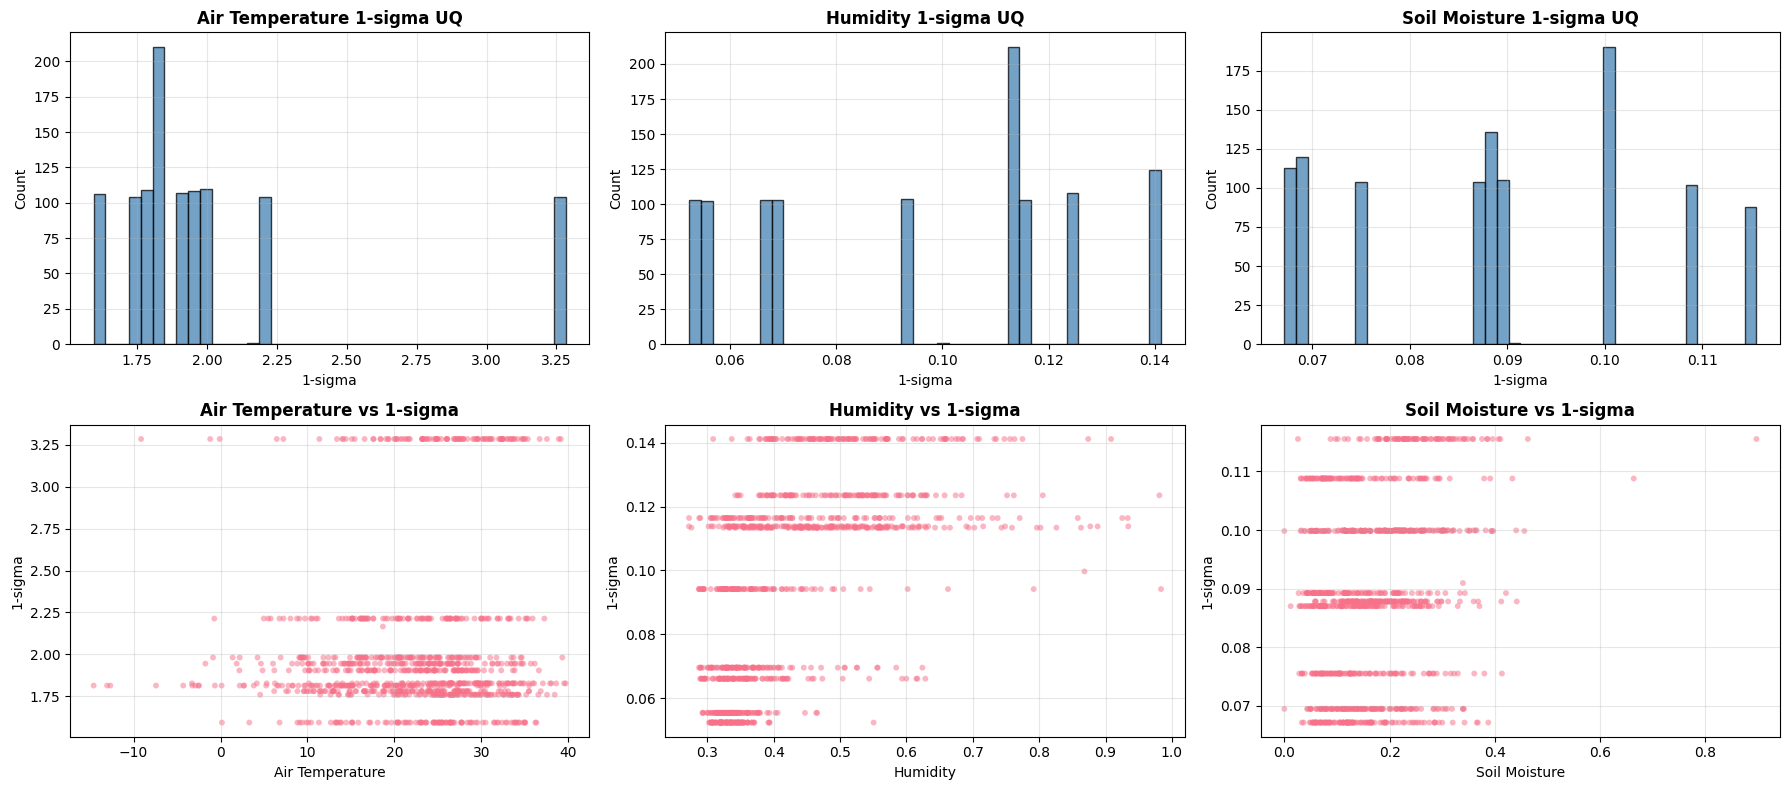

In [26]:
# Visualize variables and their 1-sigma UQ
plot_specs = [
    ("Ta_C", "Ta_C_error_sigma_empirical", "Air Temperature"),
    ("RH", "RH_error_sigma_empirical", "Humidity"),
    ("SM", "SM_error_sigma_empirical", "Soil Moisture"),
]

fig, axes = plt.subplots(2, 3, figsize=(18, 8))

for col_idx, (var_col, uq_col, label) in enumerate(plot_specs):
    # Align variable and UQ values on the same index
    aligned = pd.concat([df[var_col], uq_layers[uq_col]], axis=1, join="inner").dropna()
    aligned.columns = ["value", "uq"]

    # Top row: 1-sigma distribution
    ax_hist = axes[0, col_idx]
    ax_hist.hist(aligned["uq"], bins=40, color="steelblue", alpha=0.75, edgecolor="black")
    ax_hist.set_title(f"{label} 1-sigma UQ", fontsize=12, fontweight="bold")
    ax_hist.set_xlabel("1-sigma")
    ax_hist.set_ylabel("Count")
    ax_hist.grid(True, alpha=0.3)

    # Bottom row: variable vs 1-sigma
    ax_scatter = axes[1, col_idx]
    ax_scatter.scatter(aligned["value"], aligned["uq"], s=18, alpha=0.5, edgecolors="none")
    ax_scatter.set_title(f"{label} vs 1-sigma", fontsize=12, fontweight="bold")
    ax_scatter.set_xlabel(label)
    ax_scatter.set_ylabel("1-sigma")
    ax_scatter.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

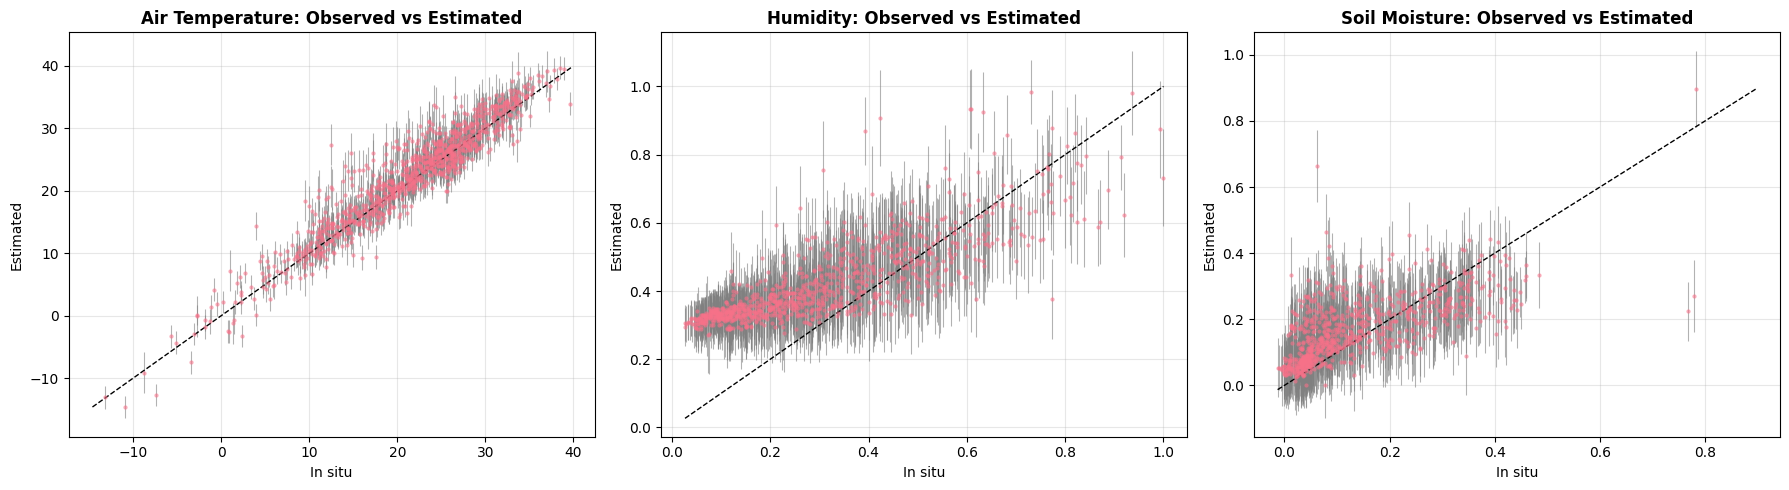

In [27]:
# Observed vs estimated with 1-sigma error bars
errorbar_specs = [
    ("insitu_Ta_C", "Ta_C", "Ta_C_error_sigma_empirical", "Air Temperature"),
    ("insitu_RH", "RH", "RH_error_sigma_empirical", "Humidity"),
    ("insitu_SM", "SM", "SM_error_sigma_empirical", "Soil Moisture"),
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (obs_col, est_col, uq_col, label) in zip(axes, errorbar_specs):
    aligned = pd.concat(
        [df[obs_col], df[est_col], uq_layers[uq_col]],
        axis=1,
        join="inner",
    ).dropna()
    aligned.columns = ["obs", "est", "sigma"]

    ax.errorbar(
        aligned["obs"],
        aligned["est"],
        yerr=aligned["sigma"],
        fmt="o",
        markersize=3,
        alpha=0.6,
        ecolor="gray",
        elinewidth=0.8,
        capsize=1.5,
        markeredgewidth=0,
    )

    # 1:1 reference line
    min_lim = min(aligned["obs"].min(), aligned["est"].min())
    max_lim = max(aligned["obs"].max(), aligned["est"].max())
    ax.plot([min_lim, max_lim], [min_lim, max_lim], "k--", linewidth=1)

    ax.set_title(f"{label}: Observed vs Estimated", fontsize=12, fontweight="bold")
    ax.set_xlabel("In situ")
    ax.set_ylabel("Estimated")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()